# Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# print(os.listdir("../input"))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
#from torch.autograd import Variable
import torch.optim as optim
import torchsummary

import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Settings

In [ ]:
batch_size = 8
image_size = 64

# Learning rate for optimizers
lr = 0.0002

# Number of channels 
channels = 3

# Number of training epochs
epochs = 150

# Latent vector (i.e Size of generator input)
latentVec = 100

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. 0 for cuda mode.
ngpu = 1

# Size of feature maps in generator
FeaGen = 64

# Size of feature maps in discriminator
FeaDis = 64

# Preparing data

In [ ]:
!unzip -q /content/drive/MyDrive/Colab_Notebooks/cycle_gan_pt/photo_sketch.zip -d /content/new

In [ ]:
!mkdir /content/new/photos
!mkdir /content/new/sketches

In [ ]:
!mv /content/new/archive-2/photos /content/new/photos
!mv /content/new/archive-2/sketches /content/new/sketches

In [ ]:
# Decide which device we want to run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crop 64x64 image
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataloader
train_data = datasets.ImageFolder("/content/new/photos/", transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size)

imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
sketch_data = datasets.ImageFolder("/content/new/sketches/", transform = transform)
sketch_loader = torch.utils.data.DataLoader(sketch_data, shuffle=False, batch_size=batch_size)

imgs1, label1 = next(iter(sketch_loader))
imgs1 = imgs1.numpy().transpose(0, 2, 3, 1)

# Model init

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

## Generator

In [ ]:
## Generator

class Generator(nn.Module):
    
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d(3, 256, 1, 4),  
            nn.BatchNorm2d(256),
            nn.ReLU(True), 

            nn.Conv2d(256, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 64, 3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
          )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(3, 256, kernel_size=(1, 1), stride=(4, 4))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tan

In [ ]:
torchsummary.summary(netG, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1        [-1, 256, 253, 253]           1,024
       BatchNorm2d-2        [-1, 256, 253, 253]             512
              ReLU-3        [-1, 256, 253, 253]               0
            Conv2d-4        [-1, 128, 126, 126]         524,416
    InstanceNorm2d-5        [-1, 128, 126, 126]               0
         LeakyReLU-6        [-1, 128, 126, 126]               0
            Conv2d-7           [-1, 64, 63, 63]          73,792
    InstanceNorm2d-8           [-1, 64, 63, 63]               0
         LeakyReLU-9           [-1, 64, 63, 63]               0
           Conv2d-10           [-1, 32, 32, 32]          18,464
   InstanceNorm2d-11           [-1, 32, 32, 32]               0
        LeakyReLU-12           [-1, 32, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           1,536
             Tanh-14            [-1, 3,

## Discriminator

In [ ]:
## Discriminator

class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1),
            nn.Flatten(), 
            nn.LazyLinear(1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): LazyLinear(in_features=0, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
torchsummary.summary(netD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
    InstanceNorm2d-4          [-1, 128, 16, 16]               0
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
    InstanceNorm2d-7            [-1, 256, 8, 8]               0
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9              [-1, 1, 7, 7]           4,097
          Flatten-10                   [-1, 49]               0
           Linear-11                    [-1, 1]              50
          Sigmoid-12                    [-1, 1]               0
Total params: 663,027
Trainable params: 663,027
Non-trainable params: 0
-------------------------------

# Training

In [ ]:
skloader = iter(sketch_loader)
sketch = next(skloader)

In [ ]:
sketch[0].shape

torch.Size([8, 3, 64, 64])

In [ ]:
netG(sketch[0].to(device))

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latentVec, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Lists to keep track of progress
Glosses = []
Dlosses = []
iters = 0
num_epochs = 30

# For each epoch
for epoch in range(num_epochs):
    # For each batch in dataloader
    for i, (data, sketch) in enumerate(zip(train_loader, sketch_loader)):
        
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with real batch
        netD.zero_grad()
        realImg = data[0].to(device)
        batch_size = realImg.size(0)
        labels = torch.full((batch_size,), real_label, device=device) # эта часть работает
        
        output = netD(realImg)

        output = output.to(torch.float32)
        labels = labels.to(torch.float32)
        print(f'Labels: {labels.shape}' )
        print(f'output: {output.shape}' )

        Real_Loss = criterion(output.squeeze(-1), labels)   # Calculate loss
        Real_Loss.backward()                    # Calculate Gradient
        Dx = output.mean().item()
        
        ## Train with fake batch
        # Generate batch of latent vectors
        # noise = torch.randn(batch_size, latentVec, 1, 1, device = device)
        fake = netG(sketch[0].to(device))
        labels.fill_(fake_label)
        output = netD(fake.detach())   # выше все работает. размер (32,1,1,1)

        output = output.squeeze(-1).squeeze(-1).squeeze(-1)

        Fake_Loss = criterion(output, labels)
        Fake_Loss.backward()
        D_G1= output.mean().item()      # выше все работает
        # Add the gradients from the all-real and all-fake batches
        DisLoss = Real_Loss + Fake_Loss
        optimizerD.step()               # выше работает
        
        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        labels.fill_(real_label)                # fake labels are real for generator cost
        output = netD(fake)

        output = output.squeeze(-1).squeeze(-1).squeeze(-1)
        GLoss = criterion(output, labels)
        GLoss.backward()
        D_G2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if iters % 70 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D Loss: %.4f] [G Loss: %.4f] [D(x): %.4f] [D(G(z)): %.4f/%.4f]' 
                  % (epoch, num_epochs, i, len(train_loader), DisLoss.item(), GLoss.item(), Dx, D_G1, D_G2))
            
            ValidImage = netG(sketch[0].to(device))
        
        iters += 1
            
        # Save Losses
        Glosses.append(GLoss.item())
        Dlosses.append(DisLoss.item())

Labels: torch.Size([8])
output: torch.Size([8, 1])
[Epoch 0/30] [Batch 0/24] [D Loss: 1.5429] [G Loss: 1.6171] [D(x): 0.4351] [D(G(z)): 0.4980/0.2000]
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: torch.Size([8, 1])
Labels: torch.Size([8])
output: t

# Check

In [ ]:
output

tensor([0.0158, 0.0006, 0.0036, 0.0008], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

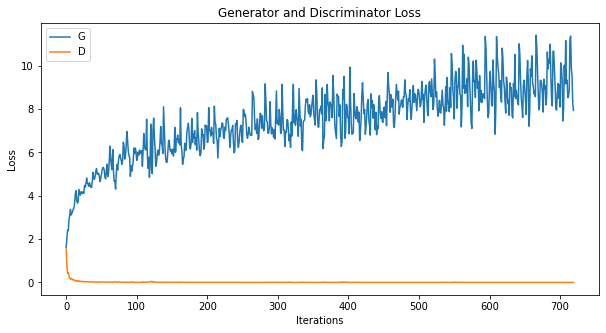

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(Dlosses)
df[df[0]>1]

,0
236,20.386066
238,4.312174
239,4.481208
240,1.541880
243,2.533586


In [ ]:
iters

576

In [ ]:
pred = netG(iter(train_loader).next()[0].to(device)).to("cpu").clone().detach()

In [ ]:
pred.size()

torch.Size([8, 3, 64, 64])

# Result

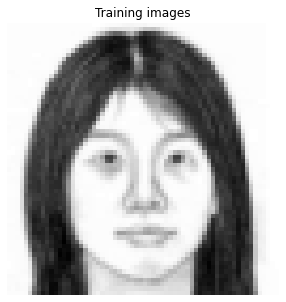

In [ ]:
TrainingImages = next(iter(sketch_loader))
# SketchImages = netG(iter(train_loader).next()[0].to(device)).to("cpu").clone().detach()
SketchImages = netG(iter(sketch_loader).next()[0].to(device)).to("cpu").clone().detach()
plt.figure(figsize=(6, 5))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(TrainingImages[0][0].to(device)[:64], padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

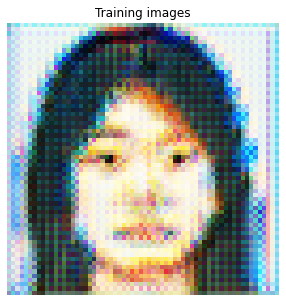

In [ ]:
plt.figure(figsize=(6, 5))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(SketchImages[0].to(device)[:64], padding=2, 
                                         normalize=True).cpu(),(1,2,0)))